<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/Practice_Metric_Learning_DeepCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf *.tgz*
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar zxf lfw-deepfunneled.tgz

--2023-01-14 19:11:27--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M   101MB/s    in 1.0s    

2023-01-14 19:11:28 (101 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]



In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import glob
import os
import collections
import random
import copy

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
os.listdir("lfw-deepfunneled")[:10], os.listdir("lfw-deepfunneled")[-10:]

(['Daniele_Bergamin',
  'Daniel_Osorno',
  'Don_Lake',
  'Pauline_Phillips',
  'Sasha_Cohen',
  'Mike_Samp',
  'Juliette_Binoche',
  'Carlos_Moya',
  'Kim_Weeks',
  'Betty_Garrison'],
 ['Ernie_Fletcher',
  'Kay_Behrensmeyer',
  'Paula_Zahn',
  'Nelson_Shanks',
  'Carolyn_Kuhl',
  'Mona_Locke',
  'Margie_Puente',
  'Davey_Johnson',
  'Jeffrey_Scott_Postell',
  'Jane_Rooney'])

In [ ]:
names = sorted(os.listdir('lfw-deepfunneled'))
name_to_classid = {data: index for index, data in enumerate(names)}
classid_to_name = {data: index for index, data in name_to_classid.items()}

# creating class ID to path dictionary
def build_data_set(names_list, start_index, end_index):
  classid_to_paths = collections.defaultdict(list)
  counter = 0
  for name in names[start_index:end_index]:
    class_id = name_to_classid[name]
    for image_name in os.listdir(f"lfw-deepfunneled/{name}"):
      classid_to_paths[class_id].append(f"lfw-deepfunneled/{name}/{image_name}")
      counter += 1
  
  print(f"Number of person: {len(classid_to_paths)}")
  print(f"Number of images: {counter}")

  return classid_to_paths

In [ ]:
print('Build Train Set...')
train_set = build_data_set(names, 0, 500)
print('Build Validation Set...')
val_set = build_data_set(names, 500, 1000)

Build Train Set...
Number of person: 500
Number of images: 1155
Build Validation Set...
Number of person: 500
Number of images: 945


Train Set: {Id: [image path 1, image path 2], .... }

Analyzing the distribution of celebrity images by frequency plots

Text(0.5, 0, 'Nb images / person')

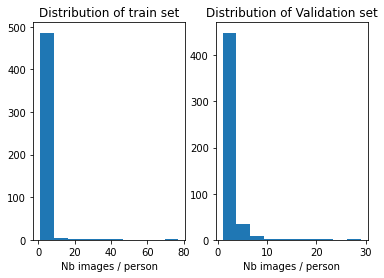

In [ ]:
plt.subplot(1,2,1)
train_occurence = {classid_to_name[class_id]: len(paths) for class_id, paths in train_set.items()}
plt.hist(train_occurence.values())
plt.title("Distribution of train set")
plt.xlabel("Nb images / person")


plt.subplot(1,2,2)
test_occurence = {classid_to_name[class_id]: len(paths) for class_id, paths in val_set.items()}
plt.hist(test_occurence.values())
plt.title("Distribution of Validation set")
plt.xlabel("Nb images / person")

In [ ]:
for name, nb in sorted(train_occurence.items(), key=lambda x: x[1], reverse=True)[:20]:
  print(f"{name}: {nb} images")

Ariel_Sharon: 77 images
Arnold_Schwarzenegger: 42 images
Alejandro_Toledo: 39 images
Andre_Agassi: 36 images
Alvaro_Uribe: 35 images
Atal_Bihari_Vajpayee: 24 images
Amelie_Mauresmo: 21 images
Angelina_Jolie: 20 images
Abdullah_Gul: 19 images
Andy_Roddick: 15 images
Ari_Fleischer: 13 images
Adrien_Brody: 12 images
Anna_Kournikova: 12 images
Ann_Veneman: 11 images
Al_Gore: 8 images
Ali_Naimi: 8 images
Ana_Palacio: 8 images
Antonio_Palocci: 8 images
Al_Sharpton: 7 images
Amelia_Vega: 7 images


## Building Positive and negative pairs of images

In [ ]:
def build_pairs(classid_to_paths, pair_per_class=50):
  """
  we are creating equal number of positive and negative pairs to
  make it more balanced
  """
  pairs = [] # a list of tuple - (img_path1, img_path2, 1) (pos pair), (img_path1, img_path2, 0) (neg pair)
  classes = set(classid_to_paths.keys())

  for class_id in classid_to_paths:
    num_img_class = len(classid_to_paths[class_id])

    if num_img_class == 1:
      continue
    
    for _ in range(min(num_img_class, pair_per_class)):
      
      # positive pair
      pairs.append((
          random.choice(classid_to_paths[class_id]),
          random.choice(classid_to_paths[class_id]),
          1.0
      ))

      # creating a negative class id
      neg_classes = classes - {class_id}
      neg_class_id = random.choice(list(neg_classes))

      # negative pair
      pairs.append((
          random.choice(classid_to_paths[class_id]),
          random.choice(classid_to_paths[neg_class_id]),
          0.0
      ))
  return pairs

In [ ]:
class SiameseDataset(torch.utils.data.Dataset):
  def __init__(self, classid_to_paths, transform, pair_per_class=20):
    self.transform = transform
    self.pairs = build_pairs(classid_to_paths, pair_per_class=pair_per_class)
  
  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, index):
    img_1, img_2, y = self.pairs[index]

    left_img  = Image.open(img_1).convert('RGB')
    right_img = Image.open(img_2).convert('RGB')

    left_img  = self.transform(left_img)
    right_img = self.transform(right_img)

    return left_img, right_img, y 

## Building Data Augmentations and Data loaders

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.CenterCrop((80,80)),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.CenterCrop((80,80)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = SiameseDataset(train_set, train_transform, pair_per_class=50)
val_dataset = SiameseDataset(val_set, train_transform, pair_per_class=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32)

len(train_loader)

49

In [ ]:
x1, x2, y = next(iter(train_loader))

x1.shape, x2.shape, y

(torch.Size([32, 3, 80, 80]),
 torch.Size([32, 3, 80, 80]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.],
        dtype=torch.float64))

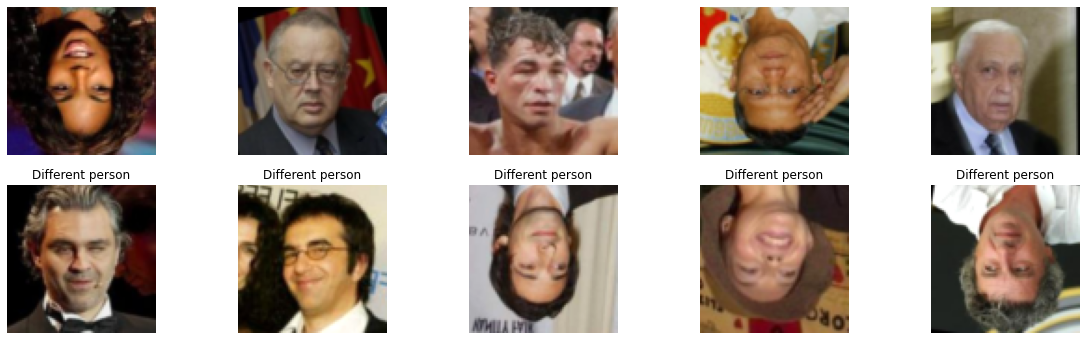

In [ ]:
plt.figure(figsize=(20, 6))

for i in range(5):
  ax = plt.subplot(2, 5, i + 1)
  ax.axis('off')
  img = (x1[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
  plt.imshow(img)

for i in range(5):
  ax = plt.subplot(2, 5, i + 1 + 5)
  ax.axis('off')
  img = (x2[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
  plt.imshow(img)
  plt.title("Same person" if y[i] == 1.0 else "Different person")

## Convolution Block

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    #print('Inside conv block')
    #print(x.shape)
    return self.conv(x)

In [ ]:
class SimpleConvBackbone(nn.Module):
  def __init__(self):
    super().__init__()

    self.convs = nn.Sequential(
        ConvBlock(3,16,3,1),
        ConvBlock(16,16,3,1),
        nn.AvgPool2d((3,3)),
        ConvBlock(16,32,5,1),
        ConvBlock(32,32,5,1),
        nn.AvgPool2d((2,2)),
        ConvBlock(32,64,3,1),
        ConvBlock(64,128,3,1),
    )

    #  self.convs = nn.Sequential(
    #     ConvBlock(3, 16, 3, 1),
    #     ConvBlock(16, 16, 3, 1),
    #     nn.MaxPool2d((2, 2)),
    #     ConvBlock(16, 32, 3, 1),
    #     ConvBlock(32, 32, 3, 1),
    #     nn.MaxPool2d((2, 2)),
    #     ConvBlock(32, 64, 3, 1),
    #     ConvBlock(64, 64, 3, 1),
    #     nn.MaxPool2d((2, 2)),
    #     ConvBlock(64, 128, 3, 1),
    #     ConvBlock(128, 128, 3, 1),
    # )

    self.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(2048, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128,50)
    )

  def forward(self, x):
    x = self.convs(x)
    #print(f'The shape of tensor after passing through convs layer: ', x.shape)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [ ]:
SimpleConvBackbone()(torch.randn(32,3,80,80)).shape

torch.Size([32, 50])

In [ ]:
x = torch.randn(32,3,80,80)
x.shape[0] == len(x)
x = x.view(x.shape[0], -1)
print(x.shape)

torch.Size([32, 19200])


### Pairwise cosine similarity for two tensors of shape (n,d) that computes cosine similarity along the rows

In [ ]:
def tensor_cosine(x, y):
  x = F.normalize(x,p=2,dim=1)
  y = F.normalize(y,p=2,dim=1)

  res = torch.tensordot(x,torch.transpose(y, 0, 1), dims=1)
  # print('res tensor: ', res.is_cuda)
  # print('eye: ', torch.eye(res.shape[0], res.shape[1]).is_cuda)
  eye = torch.eye(res.shape[0], res.shape[1]).cuda()
  # print(res.is_cuda)
  res = torch.sum(res.cuda() * eye,dim=1)

  return res  


x = torch.randn(3, 5)
y = torch.randn(3, 5)

F.cosine_similarity(x, y), tensor_cosine(x, y)

(tensor([ 0.1320, -0.4156, -0.1940]),
 tensor([ 0.1320, -0.4156, -0.1940], device='cuda:0'))

## Main Network

In [ ]:
class Siamese(nn.Module):
  def __init__(self):
    super().__init__()
    self.backbone = SimpleConvBackbone()
  
  def forward(self, x1, x2):
    embedding_1 = self.backbone(x1)
    embedding_2 = self.backbone(x2)

    cos = tensor_cosine(embedding_1, embedding_2)
    return cos

Custom Loss Function: Contrastive Loss: $$y (1 - \hat{y})^2 + (1 - y) \operatorname{max}^2(\hat{y} - m, 0)  $$

Notice that the ground-truth ($y = 1$ same person, $y = 0$ different person) acts as a gate between the two parts of the loss.

In [ ]:
def contrastive_loss(pred_simi, gt_simi, margin=0.20):
  pos_pair =  gt_simi * (1 - pred_simi)
  neg_pair = (1 - gt_simi) * torch.clamp(pred_simi - margin, min=0.)

  pos_pair = pos_pair ** 2
  neg_pair = neg_pair ** 2

  # Note that `gt_simi` acts here as a gate to avoid doing a for-loop and if/else
  return torch.mean(pos_pair + neg_pair) 

In [ ]:
def eval_model(model, loader):
  model.eval()
  acc, loss = 0., 0.
  counter = 0
  for x1, x2, gt_simi in loader:
    with torch.no_grad():
      #print(x1.shape)
      pred_simi = model(x1.cuda(), x2.cuda()).cpu()
      #print('pred_simi shape: ', pred_simi.shape)
    
    loss += contrastive_loss(pred_simi, gt_simi).item()
    acc += ((pred_simi > 0.5).float() == gt_simi).sum().item()
    #print('mask printing: ', ((pred_simi > 0.5).float()))
    counter += len(x1)

  #print('Counter: ', counter)
  acc /= counter
  #print('Loader Length / batch size: ', len(loader))
  loss /= len(loader)
  model.train()
  return round(100 * acc, 2), round(loss, 5)


In [ ]:
model = Siamese().cuda()
best_model, best_acc = None, 0.0

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

val_acc, val_loss = eval_model(model, test_loader)
print(f"Random model --> Val loss: {val_loss}, val accuracy: {val_acc}")
epochs = 15
margin = 0.0

for epoch in range(epochs):
  losses = 0
  for x1, x2, y in train_loader:
    x1, x2, y = x1.cuda(), x2.cuda(), y.cuda()

    optimizer.zero_grad()

    pred_simi = model(x1, x2)

    loss = contrastive_loss(pred_simi, y, margin=margin)
    loss.backward()
    optimizer.step()

    losses += loss.item()

  print(len(train_loader))
  print(f"Epoch {epoch}: Train loss: {round(losses/len(train_loader),5)}")

  val_acc, val_loss = eval_model(model, test_loader)
  print(f"\tVal loss: {val_loss}, val accuracy: {val_acc}")

  if best_acc <= val_acc:
    print("\tCheckpointing!")
    best_acc = val_acc
    best_model = copy.deepcopy(model)

Random model --> Val loss: 0.32, val accuracy: 50.0
49
Epoch 0: Train loss: 0.26488
	Val loss: 0.17946, val accuracy: 53.97
	Checkpointing!
49
Epoch 1: Train loss: 0.26085
	Val loss: 0.18068, val accuracy: 59.8
	Checkpointing!
49
Epoch 2: Train loss: 0.24553
	Val loss: 0.16897, val accuracy: 60.73
	Checkpointing!
49
Epoch 3: Train loss: 0.23063
	Val loss: 0.1682, val accuracy: 57.85
49
Epoch 4: Train loss: 0.23704
	Val loss: 0.1759, val accuracy: 62.33
	Checkpointing!
49
Epoch 5: Train loss: 0.21755
	Val loss: 0.154, val accuracy: 63.43
	Checkpointing!
49
Epoch 6: Train loss: 0.21205
	Val loss: 0.17172, val accuracy: 58.61
49
Epoch 7: Train loss: 0.21544
	Val loss: 0.14874, val accuracy: 66.22
	Checkpointing!
49
Epoch 8: Train loss: 0.19718
	Val loss: 0.1564, val accuracy: 63.26
49
Epoch 9: Train loss: 0.18741
	Val loss: 0.16917, val accuracy: 63.43
49
Epoch 10: Train loss: 0.19802
	Val loss: 0.1527, val accuracy: 66.39
	Checkpointing!
49
Epoch 11: Train loss: 0.17983
	Val loss: 0.1578

In [ ]:
names = []
embeddings = []
paths = []

for class_id, class_paths in val_set.items():
  for path in class_paths:
    paths.append(path)
    names.append(classid_to_name[class_id])

    img = Image.open(path).convert('RGB')
    img = val_transform(img)
    with torch.no_grad():
      emb = best_model.backbone(img[None].cuda())[0]
      print(emb.shape)
    embeddings.append(emb)

embeddings = torch.stack(embeddings)
embeddings.shape

torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50

torch.Size([945, 50])

In [ ]:
for name, nb in sorted(test_occurence.items(), key=lambda x: x[1], reverse=True)[:10]:
  print(f"{name} ({name_to_classid[name]}): {nb} images")

Bill_Clinton (531): 29 images
Carlos_Menem (786): 21 images
Carlos_Moya (788): 19 images
Bill_Gates (538): 17 images
Bill_Simon (560): 15 images
Britney_Spears (706): 14 images
Charles_Moose (876): 13 images
Catherine_Zeta-Jones (831): 11 images
Bill_McBride (549): 10 images
Bill_Frist (537): 9 images


There are 29 images with Bill_Clinton's face.
tensor([0], device='cuda:0')


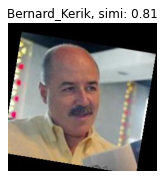

In [ ]:
selected_name = "Bill_Clinton"

print(f"There are {names.count(selected_name)} images with {selected_name}'s face.")
idx = random.choice([i for i, name in enumerate(names) if name == selected_name])

similarities = tensor_cosine(embeddings[idx][None], embeddings)
closest_indexes = similarities.argsort()[-10:].flip(0)
closest_simis = similarities[closest_indexes]
print(closest_indexes)


plt.figure(figsize=(20, 6))

for i, (closest_index, closest_simi) in enumerate(zip(closest_indexes, closest_simis), start=1):
  ax = plt.subplot(2, 5, i)
  ax.axis('off')

  path, name = paths[closest_index], names[closest_index]

  img = Image.open(path).convert('RGB')
  plt.imshow(img)
  plt.title(f"{name}, simi: {round(closest_simi.item(), 2)}")

